In [35]:
#%%file IBP/generate_data.py

from __future__ import division
import numpy as np
import os
import math

np.random.seed(123)

#weights matrix
A=np.array([[1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
   [0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0],
   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,1,1,1]])

#data simulation
N=100
D=36
 
true_sig_x=0.5

true_Z=np.zeros((N,4))
X=np.zeros((N,D))

for i in range(N):
    true_Z[i,:]=(np.random.rand(4)>0.5)
    while sum(true_Z[i,:])==0:
        true_Z[i,:]=(np.random.rand(4)>0.5)
    X[i,:]=np.random.normal(0,1,D) @ np.diag([true_sig_x]*D)+true_Z[i,:] @ A

#creating folder if not present
if not os.path.exists('data_files'):
    os.makedirs('data_files')

#saving simulated data    
np.savetxt('data_files/true_Z.csv', true_Z, delimiter=',')
np.savetxt('data_files/true_X.csv', X, delimiter=',')
np.savetxt('data_files/true_A.csv', A, delimiter=',')

In [36]:
%%file IBP/new_K.py

from __future__ import division
import numpy as np
import numpy.linalg
import math
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv
from .likelihood import full_X
#sample the number of new dishes
np.random.seed(123)

def new_K(alpha,X,N,Z,s_x,s_a,obj):
    k_prob = np.zeros(5)
    for i in range(0,5):
        l = alpha/N
        new_zi = np.zeros((N,i))
        new_zi[obj,:] = np.ones((1,i))
        new_Z = np.hstack([Z,new_zi.reshape(N,i)])
        LH = full_X(new_Z,X,s_x, s_a)
        log_prior = i*np.log(l)-l-np.log(math.factorial(i))
        k_prob[i] = LH + log_prior#likelihood*prior = posterior
 
    k_prob = np.exp(k_prob-max(k_prob))
    k_prob = k_prob/sum(k_prob)
    if (abs(sum(k_prob)-1)>0.001):
        return(sum(k_prob),'wrong k sum')
    
    new_k = np.random.choice(5,1,p = k_prob)
    return (new_k)

Overwriting IBP/new_K.py


In [37]:
%%file IBP/new_K_speed.py

from __future__ import division
import numpy as np
import numpy.linalg
import math
from .likelihood_new import full_X_new
#sample the number of new dishes
np.random.seed(123)

def new_K_speed(alpha,X,N,Z,s_x,s_a,obj):
    k_prob = np.zeros(5)
    for i in range(0,5):
        l = alpha/N
        new_zi = np.zeros((N,i))
        new_zi[obj,:] = np.ones((1,i))
        new_Z = np.hstack([Z,new_zi.reshape(N,i)])
        LH = full_X(new_Z,X,s_x, s_a)
        log_prior = i*np.log(l)-l-np.log(math.factorial(i))
        k_prob[i] = LH + log_prior#likelihood*prior = posterior
 
    k_prob = np.exp(k_prob-max(k_prob))
    k_prob = k_prob/sum(k_prob)
    if (abs(sum(k_prob)-1)>0.001):
        return(sum(k_prob),'wrong k sum')
    
    new_k = np.random.choice(5,1,p = k_prob)
    return (new_k)

Overwriting IBP/new_K_speed.py


In [38]:
import time
from IBP import new_K, new_K_speed
t0=time.time()
for i in range(1000):
    new_K(1,X,N, Z, 0.5, 1.7,)
t1=time.time()
elapsed_likelihood1=t1-t0

t0=time.time()
for i in range(1000):
    full_X_new(X, Z, 0.5, 1.7)
t1=time.time()
elapsed_likelihood2=t1-t0

elapsed_likelihood1,elapsed_likelihood2

TypeError: new_K() missing 1 required positional argument: 'obj'

In [39]:
%%file IBP/likelihood.py

from __future__ import division
import numpy as np
import numpy.linalg
import math
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv

#compute likelihood
np.random.seed(123)
def full_X(Z,X,s_x,s_a):
    D = X.shape[1]
    N = Z.shape[0]
    K = Z.shape[1]
    """The constant part"""
    zz = Z.T@Z+np.diag([(s_x**2)/(s_a**2)]*K) #zz -- K*K
    determ = np.linalg.det(zz)
    log_const = 0.5*N*D*np.log(2*np.pi)+(N-K)*D*np.log(s_x)+K*D*np.log(s_a)+0.5*D*np.log(determ)
    log_const = -log_const
    """The exponential part"""
    L = np.linalg.cholesky(zz)
    inv_L = np.linalg.inv(L)
    ii =  np.eye(N)-(Z @ inv_L.T @ inv_L @ Z.T)
    tr =  np.trace(X.T @ ii @X)
    expon = -tr/(2*s_x**2)
    return(log_const+expon)

Overwriting IBP/likelihood.py


In [40]:
%%file IBP/likelihood_new.py

from __future__ import division
import numpy as np
import numpy.linalg
import math

#compute likelihood
np.random.seed(123)
def full_X_new(Z,X,s_x,s_a):
    D = X.shape[1]
    N = Z.shape[0]
    K = Z.shape[1]
    """The constant part"""
    zz = Z.T@Z+np.diag([(s_x**2)/(s_a**2)]*K) #zz -- K*K
    determ = np.linalg.det(zz)
    log_const = 0.5*N*D*np.log(2*np.pi)+(N-K)*D*np.log(s_x)+K*D*np.log(s_a)+0.5*D*np.log(determ)
    log_const = -log_const
    """The exponential part"""
    ii =  np.eye(N)-(Z @ np.linalg.inv(zz) @ Z.T)
    tr =  np.trace(X.T @ ii @X)
    expon = -tr/(2*s_x**2)
    return(log_const+expon)

Overwriting IBP/likelihood_new.py


In [41]:
import numpy as np
X=np.genfromtxt("data_files/true_X.csv", delimiter=",")
Z=np.genfromtxt("data_files/true_Z.csv", delimiter=",")

In [42]:
import multiprocessing
multiprocessing.cpu_count()

8

In [43]:
from IBP import full_X, full_X_new
from multiprocessing import Pool

def full_X_process(Z,X,s_x,s_a):
    return full_X(Z,X,s_x,s_a)

args = [(X, Z, 0.5, 1.7)]

t0=time.time()
with Pool(processes=8) as pool:
    pool.starmap(full_X_process, args*1000)
t1=time.time()
elapsed_likelihoodpro1=t1-t0
elapsed_likelihoodpro1

28.823383808135986

In [44]:
from concurrent.futures import ThreadPoolExecutor

def full_X_thread(Z,X,s_x,s_a):
    return full_X(Z,X,s_x,s_a)

args = [(X, Z, 0.5, 1.7)]
t0=time.time()
with ThreadPoolExecutor(max_workers=4) as pool:
    pool.map(lambda x: full_X_thread(x[0], x[1],x[2], x[3]), args*1000)
t1=time.time()
elapsed_likelihoodThread1=t1-t0
elapsed_likelihoodThread1

32.196438789367676

In [45]:
from ipyparallel import Client
rc = Client()
rc.ids
dv = rc[:]

def full_X_ipy(Z,X,s_x,s_a):
    return full_X(Z,X,s_x,s_a)

args = [(X, Z, 0.5, 1.7)]
t0=time.time()
dv.map(lambda x: full_X_ipy(x[0], x[1],x[2], x[3]), args*1000)
t1=time.time()
elapsed_likelihoodipy1=t1-t0
elapsed_likelihoodipy1

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


OSError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

In [ ]:
#from IBP import full_X
import time
from IBP import full_X, full_X_new
t0=time.time()
for i in range(1000):
    full_X(X, Z, 0.5, 1.7)
t1=time.time()
elapsed_likelihood1=t1-t0

t0=time.time()
for i in range(1000):
    full_X_new(X, Z, 0.5, 1.7)
t1=time.time()
elapsed_likelihood2=t1-t0

elapsed_likelihood1,elapsed_likelihood2

In [ ]:
%%time
for i in range(1000):
    full_X_new(X, Z, 0.5, 1.7)

In [ ]:
%%file IBP/gibbs.py

from __future__ import division
import numpy as np
import numpy.linalg
import math
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv
from IBP import new_K
from IBP import full_X 
#initial alpha, K_p, sigma_x, sigma_a

np.random.seed(123)

def gibbs_sampler(X,init_alpha,init_sig_x,init_sig_a,seed,mcmc):
    N = X.shape[0]
    chain_alpha = np.zeros(mcmc)
    chain_sigma_a = np.zeros(mcmc)
    chain_sigma_x = np.zeros(mcmc)
    chain_K = np.zeros(mcmc)
    chain_Z = list()
    #initial matrix Z
    Z = np.array(np.random.choice(2,N,p = [0.5,0.5])).reshape(N,1)

    chain_alpha[0] = alpha = init_alpha 
    chain_sigma_a[0] = sigma_a = init_sig_a 
    chain_sigma_x[0] = sigma_x = init_sig_x
    chain_K[0] = K = 1
    chain_Z.append(Z)
    P = np.zeros(2)
    
    Hn = 0
    for i in range(1,mcmc):
        #gibbs
        alpha = np.random.gamma(1+K,1/(1+Hn))
        print(i,K)
        Hn = 0
        for im in range(0,N): #loop over images
            Hn = Hn + 1/(im+1)
            #sample new Z_i
            for k in range(0,K):#loop over features
                zk_sum = np.sum(Z[:,k])
                if zk_sum == 0:
                     lz = -10**5
                else:
                     lz = np.log(zk_sum)-np.log(N)
                if zk_sum == N:
                     lz0 = -10**5
                else:
                     lz0 = np.log(N-zk_sum)-np.log(N)
                Z[im,k] = 1
                P[0] = full_X(Z,X,sigma_x,sigma_a)+lz
                Z[im,k] = 0
                P[1] = full_X(Z,X,sigma_x,sigma_a)+lz0

                P=np.exp(P - max(P))
                P[0] = P[0]/(P[0]+P[1])
                if np.random.uniform(0,1,1)<P[0]:
                    Z[im,k] = 1
                else:
                    Z[im,k] = 0

            #sample K---num of new features
            new_k = new_K(alpha,X,N,Z,sigma_x,sigma_a,im)[0]
            if Z.shape[1]>(K+new_k):
                Ztemp=Z
                Ztemp[im,K:(K+new_k)]=1       
            else:
                Ztemp=np.zeros((Z.shape[0],K+new_k))
                Ztemp[0:Z.shape[0],0:Z.shape[1]]=Z
                Ztemp[im,K:(K+new_k)] = 1

            Z=Ztemp
            K = K + new_k

            #sample a new sigma_x and sigma_a with MH,invgamma(2,2) prior/invgamma(1,1) proposal
            #for mh in range(0,5):
            '''propose new sigma_x'''
            current_LH = full_X(Z,X,sigma_x,sigma_a)
            #sig_x_str = sigma_x + (np.random.rand(1)[0]-0.5)
            sig_x_str = 1/np.random.gamma(3,2)#propose a new sigma_x from invgamma(3,2)
            pos_str = full_X(Z,X,sig_x_str,sigma_a)-3*np.log(sig_x_str)-1/(2*sig_x_str)
            pos = current_LH-3*np.log(sigma_x)-1/(2*sigma_x)
            if((pos_str-pos)>0):
                sigma_x = sig_x_str
            else:
                move = np.random.rand(1)
                if(np.log(move[0]) < (pos_str-pos)):
                    sigma_x = sig_x_str
                '''propose new sigma_a'''
            #sig_a_str = sigma_a + (np.random.rand(1)[0]-0.5)
            sig_a_str = 1/np.random.gamma(3,2)
            pos_str = full_X(Z,X,sigma_x,sig_a_str)-3*np.log(sig_a_str)-1/(2*sig_a_str)
            pos = current_LH-3*np.log(sigma_a)-1/(2*sigma_a)
            if((pos_str-pos) > 0):
                sigma_a = sig_a_str
            else:
                move = np.random.rand(1)
                if(np.log(move[0]) < (pos_str-pos)):
                    sigma_a = sig_a_str

        #remove features that have only 1 object
        index = np.sum(Z,0)>1
        Z = Z[:,index]
        K = Z.shape[1]

        #store chain values                
        chain_alpha[i] = alpha
        chain_sigma_a[i] = sigma_a
        chain_sigma_x[i] = sigma_x
        chain_K[i] = K
        chain_Z.append(Z)
        
    return(chain_alpha,chain_sigma_a,chain_sigma_x,chain_K,chain_Z)



In [ ]:
#call gibbs sampler function on simulated data
#al,a,x,kp = gibbs_sampler(X,1,0.5,1.7,123,200)

In [ ]:
import numpy as np
import time
from IBP import gibbs_sampler

#load data
X=np.genfromtxt("data_files/true_X.csv", delimiter=",")

In [ ]:
import profile
profile.run("gibbs_sampler(X,init_alpha=1,init_sig_x=0.5,init_sig_a=1.7,seed=123,mcmc=10);print")

In [ ]:
t0 = time.time()
chain_alpha1,chain_sigma_a1,chain_sigma_x1,chain_K1,chain_Z1 = gibbs_sampler(X,init_alpha=1,init_sig_x=0.5,init_sig_a=1.7,seed=123,mcmc=1000)
t1 = time.time()
total=t1-t0
total

In [ ]:
%load_ext Cython

In [ ]:
%%file IBP/cython_setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("cython_functions.pyx")
)

In [134]:
%%file IBP/cython_functions.pyx

from __future__ import division
import numpy as np
import math

np.random.seed(123)

def new_K(alpha,X,N,Z,s_x,s_a,obj):
    k_prob = np.zeros(5)
    for i in range(0,5):
        l = alpha/N
        new_zi = np.zeros((N,i))
        new_zi[obj,:] = np.ones((1,i))
        new_Z = np.hstack([Z,new_zi.reshape(N,i)])
        LH = full_X(new_Z,X,s_x, s_a)
        log_prior = i*np.log(l)-l-np.log(math.factorial(i))
        k_prob[i] = LH + log_prior#likelihood*prior = posterior
 
    k_prob = np.exp(k_prob-max(k_prob))
    k_prob = k_prob/sum(k_prob)
    if (abs(sum(k_prob)-1)>0.001):
        return(sum(k_prob),'wrong k sum')
    
    new_k = np.random.choice(5,1,p = k_prob)
    return (new_k)

def full_X(Z,X,s_x,s_a):
    D = X.shape[1]
    N = Z.shape[0]
    K = Z.shape[1]
    """The constant part"""
    zz = Z.T@Z+np.diag([(s_x**2)/(s_a**2)]*K) #zz -- K*K
    determ = np.linalg.det(zz)
    log_const = 0.5*N*D*np.log(2*np.pi)+(N-K)*D*np.log(s_x)+K*D*np.log(s_a)+0.5*D*np.log(determ)
    log_const = -log_const
    """The exponential part"""
    L = np.linalg.cholesky(zz)
    inv_L = np.linalg.inv(L)
    ii =  np.eye(N)-(Z @ inv_L.T @ inv_L @ Z.T)
    tr =  np.trace(X.T @ ii @X)
    expon = -tr/(2*s_x**2)
    return(log_const+expon)



Overwriting IBP/cython_functions.pyx


In [150]:
%%file IBP/sampler_cython.py

from __future__ import division
import numpy as np
import math
from cython_functions import new_K, full_X

def gibbs_sampler_cython(X,init_alpha,init_sig_x,init_sig_a,seed,mcmc):
    N = X.shape[0]
    chain_alpha = np.zeros(mcmc)
    chain_sigma_a = np.zeros(mcmc)
    chain_sigma_x = np.zeros(mcmc)
    chain_K = np.zeros(mcmc)
    chain_Z = list()
    #initial matrix Z
    Z = np.array(np.random.choice(2,N,p = [0.5,0.5])).reshape(N,1)

    chain_alpha[0] = alpha = init_alpha 
    chain_sigma_a[0] = sigma_a = init_sig_a 
    chain_sigma_x[0] = sigma_x = init_sig_x
    chain_K[0] = K = 1
    chain_Z.append(Z)
    P = np.zeros(2)
    
    Hn = 0
    for i in range(1,mcmc):
        #gibbs
        alpha = np.random.gamma(1+K,1/(1+Hn))
        print(i,K)
        Hn = 0
        for im in range(0,N): #loop over images
            Hn = Hn + 1/(im+1)
            #sample new Z_i
            for k in range(0,K):#loop over features
                zk_sum = np.sum(Z[:,k])
                if zk_sum == 0:
                     lz = -10**5
                else:
                     lz = np.log(zk_sum)-np.log(N)
                if zk_sum == N:
                     lz0 = -10**5
                else:
                     lz0 = np.log(N-zk_sum)-np.log(N)
                Z[im,k] = 1
                P[0] = full_X(Z,X,sigma_x,sigma_a)+lz
                Z[im,k] = 0
                P[1] = full_X(Z,X,sigma_x,sigma_a)+lz0

                P=np.exp(P - max(P))
                P[0] = P[0]/(P[0]+P[1])
                if np.random.uniform(0,1,1)<P[0]:
                    Z[im,k] = 1
                else:
                    Z[im,k] = 0

            #sample K---num of new features
            new_k = new_K(alpha,X,N,Z,sigma_x,sigma_a,im)[0]
            if Z.shape[1]>(K+new_k):
                Ztemp=Z
                Ztemp[im,K:(K+new_k)]=1       
            else:
                Ztemp=np.zeros((Z.shape[0],K+new_k))
                Ztemp[0:Z.shape[0],0:Z.shape[1]]=Z
                Ztemp[im,K:(K+new_k)] = 1

            Z=Ztemp
            K = K + new_k

            #sample a new sigma_x and sigma_a with MH,invgamma(2,2) prior/invgamma(1,1) proposal
            #for mh in range(0,5):
            '''propose new sigma_x'''
            current_LH = full_X(Z,X,sigma_x,sigma_a)
            #sig_x_str = sigma_x + (np.random.rand(1)[0]-0.5)
            sig_x_str = 1/np.random.gamma(3,2)#propose a new sigma_x from invgamma(3,2)
            pos_str = full_X(Z,X,sig_x_str,sigma_a)-3*np.log(sig_x_str)-1/(2*sig_x_str)
            pos = current_LH-3*np.log(sigma_x)-1/(2*sigma_x)
            if((pos_str-pos)>0):
                sigma_x = sig_x_str
            else:
                move = np.random.rand(1)
                if(np.log(move[0]) < (pos_str-pos)):
                    sigma_x = sig_x_str
                '''propose new sigma_a'''
            #sig_a_str = sigma_a + (np.random.rand(1)[0]-0.5)
            sig_a_str = 1/np.random.gamma(3,2)
            pos_str = full_X(Z,X,sigma_x,sig_a_str)-3*np.log(sig_a_str)-1/(2*sig_a_str)
            pos = current_LH-3*np.log(sigma_a)-1/(2*sigma_a)
            if((pos_str-pos) > 0):
                sigma_a = sig_a_str
            else:
                move = np.random.rand(1)
                if(np.log(move[0]) < (pos_str-pos)):
                    sigma_a = sig_a_str

        #remove features that have only 1 object
        index = np.sum(Z,0)>1
        Z = Z[:,index]
        K = Z.shape[1]

        #store chain values                
        chain_alpha[i] = alpha
        chain_sigma_a[i] = sigma_a
        chain_sigma_x[i] = sigma_x
        chain_K[i] = K
        chain_Z.append(Z)
        
    return(chain_alpha,chain_sigma_a,chain_sigma_x,chain_K,chain_Z)

Overwriting IBP/sampler_cython.py


In [151]:
! python IBP/cython_setup.py build_ext --inplace

Traceback (most recent call last):
  File "IBP/cython_setup.py", line 5, in <module>
    ext_modules = cythonize("cython_functions.pyx")
  File "/opt/conda/lib/python3.6/site-packages/Cython/Build/Dependencies.py", line 897, in cythonize
    aliases=aliases)
  File "/opt/conda/lib/python3.6/site-packages/Cython/Build/Dependencies.py", line 777, in create_extension_list
    for file in nonempty(sorted(extended_iglob(filepattern)), "'%s' doesn't match any files" % filepattern):
  File "/opt/conda/lib/python3.6/site-packages/Cython/Build/Dependencies.py", line 102, in nonempty
    raise ValueError(error_msg)
ValueError: 'cython_functions.pyx' doesn't match any files


In [ ]:
python IBP/cython_setup.py build_ext
sudo python IBP/cython_setup.py install

In [ ]:
t0 = time.time()
chain_alpha2,chain_sigma_a2,chain_sigma_x2,chain_K2,chain_Z2 = gibbs_sampler_cython(X,init_alpha=1,init_sig_x=0.5,init_sig_a=1.7,seed=123,mcmc=1000)
t1 = time.time()
total=t1-t0
total

In [144]:
t0 = time.time()
chain_alpha,chain_sigma_a,chain_sigma_x,chain_K,chain_Z = gibbs_sampler_cython(X,init_alpha=1,init_sig_x=0.5,init_sig_a=1.7,seed=123,mcmc=1000)
t1 = time.time()
total=t1-t0
total

1 1
2 4
3 2
4 2
5 2
6 2
7 3
8 3
9 3
10 3
11 4
12 4
13 4
14 4
15 5
16 5
17 4
18 5
19 5
20 5
21 5
22 5
23 5
24 5
25 5
26 5
27 5
28 5
29 5
30 5
31 5
32 5
33 5
34 5
35 5
36 7
37 5
38 5
39 5
40 5
41 5
42 5
43 5
44 5
45 6
46 5
47 6
48 5
49 6
50 5
51 5
52 5
53 5
54 6
55 6
56 5
57 5
58 5
59 6
60 5
61 5
62 5
63 5
64 5
65 5
66 5
67 5
68 5
69 5
70 6
71 6
72 6
73 6
74 5
75 5
76 5
77 5
78 4
79 5
80 5
81 4
82 4
83 4
84 4
85 4
86 4
87 4
88 5
89 5
90 5
91 5
92 5
93 5
94 5
95 5
96 5
97 4
98 4
99 4
100 4
101 4
102 4
103 4
104 4
105 4
106 4
107 5
108 5
109 5
110 5
111 5
112 5
113 5
114 5
115 6
116 4
117 4
118 4
119 5
120 5
121 5
122 5
123 5
124 6
125 6
126 5
127 5
128 5
129 5
130 5
131 5
132 5
133 5
134 5
135 5
136 5
137 5
138 5
139 5
140 5
141 5
142 6
143 5
144 5
145 5
146 5
147 5
148 5
149 5
150 5
151 5
152 5
153 5
154 5
155 5
156 5
157 6
158 5
159 5
160 5
161 5
162 6
163 5
164 5
165 5
166 5
167 5
168 5
169 5
170 5
171 5
172 5
173 5
174 5
175 5
176 5
177 5
178 5
179 5
180 5
181 5
182 5
183 5
184 5
185 

722.8804

In [155]:
#creating folder if not present
if not os.path.exists('data_files'):
    os.makedirs('data_files')

#np.save('data_files/chain_Z', chain_Z)
np.save('data_files/chain_K', chain_K)
np.save('data_files/chain_sigma_A', chain_sigma_a)
np.save('data_files/chain_sigma_X', chain_sigma_x)
np.save('data_files/chain_alpha', chain_alpha)


In [156]:
#trace plot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.testing as npt
%matplotlib inline
%precision 4
plt.style.use('ggplot')

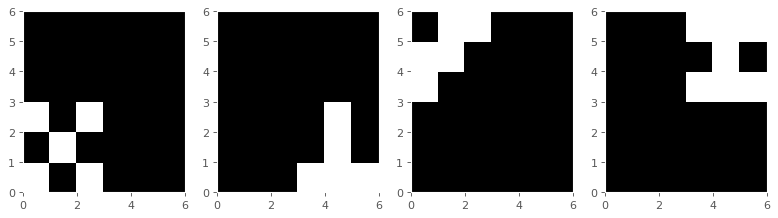

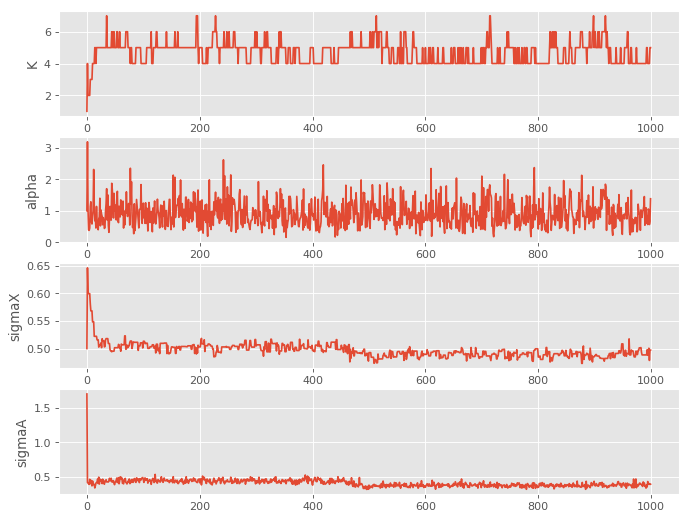

In [154]:
#obtaining histograms
#chain_Z=np.load('data_files/chain_Z.npy')
chain_K=np.load('data_files/chain_K.npy')
chain_sigma_X=np.load('data_files/chain_sigma_X.npy')
chain_sigma_A=np.load('data_files/chain_sigma_A.npy')
chain_alpha=np.load('data_files/chain_alpha.npy')

A=np.genfromtxt("data_files/A_orig.csv", delimiter=",")

#obtaining feature images
plt.figure(num=None, figsize=(12,3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(A[0,:].reshape(6,6),cmap=plt.cm.gray)     
plt.subplot(142)
plt.pcolormesh(A[1,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(143)
plt.pcolormesh(A[2,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(144)
plt.pcolormesh(A[3,:].reshape(6,6),cmap=plt.cm.gray) 
plt.savefig('data_files/features.png')

#making trace plots
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(411)
plt.plot(chain_K)
plt.ylabel('K')
plt.subplot(412)
plt.plot(chain_alpha)
plt.ylabel('alpha')
plt.subplot(413)
plt.plot(chain_sigma_X)
plt.ylabel('sigmaX')
plt.subplot(414)
plt.plot(chain_sigma_A)
plt.ylabel('sigmaA')
plt.savefig('data_files/trace_plots.png')

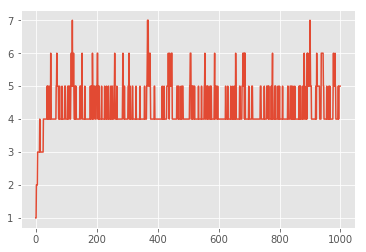

In [93]:
plt.plot(chain_K,label='$y = K')
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x, y, label='$y = numbers')
plt.title('Legend inside')
ax.legend()
#plt.show()
 
fig.savefig('plot.png')

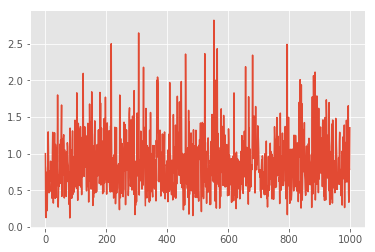

In [89]:
plt.plot(chain_alpha)

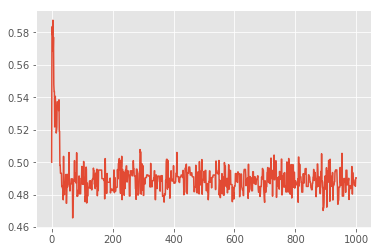

In [87]:
plt.plot(chain_sigma_x)

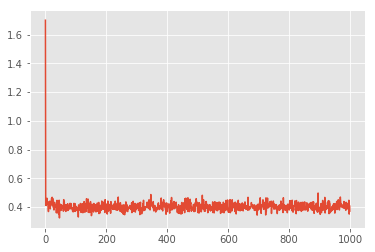

In [88]:
plt.plot(chain_sigma_a)

(array([  0.,   2.,   4.,  18., 695., 230.,  47.,   4.,   0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

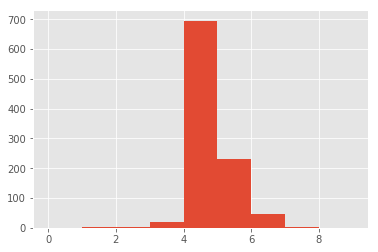

In [90]:
plt.hist(chain_K,bins=range(10))

In [ ]:
#hist

plt.figure(num=None, figsize=(12,3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.hist(chain_K[200:],bins=range(12),normed=True,color='black')
plt.xlabel('(a) Posterior distribution of K')
m=np.mean(chain_Z, axis=0)
plt.subplot(122)
plt.hist(np.ceil(np.sum(m,axis=1)),bins=range(10),normed=True,color='black')
plt.xlabel('(b) Features (ordered by frequency of occurence)')
plt.savefig('data_files/figures.png')



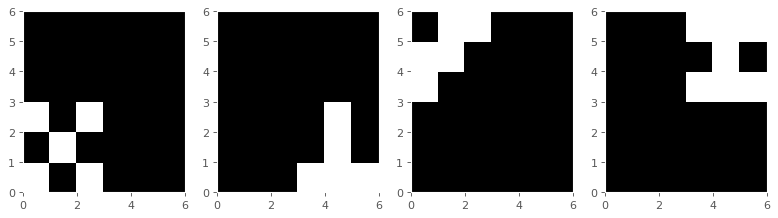

In [112]:
plt.figure(num=None, figsize=(12,3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(A[0,:].reshape(6,6),cmap=plt.cm.gray)     
plt.subplot(142)
plt.pcolormesh(A[1,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(143)
plt.pcolormesh(A[2,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(144)
plt.pcolormesh(A[3,:].reshape(6,6),cmap=plt.cm.gray)  

In [50]:
Z=chain_Z[999].reshape(100,6)
sigma_X=chain_sigma_x[999]
sigma_A=chain_sigma_a[999]
A_inf=np.dot(np.dot(np.linalg.inv((np.dot(Z.T,Z)+(sigma_X/sigma_A)*np.eye(6))),Z.T),X)

NameError: name 'A_inf' is not defined

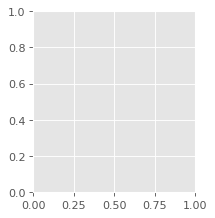

In [97]:
plt.figure(num=None, figsize=(12,3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(A_inf[0,:].reshape(6,6),cmap=plt.cm.gray)     
plt.subplot(142)
plt.pcolormesh(A_inf[1,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(143)
plt.pcolormesh(A_inf[2,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(144)
plt.pcolormesh(A_inf[3,:].reshape(6,6),cmap=plt.cm.gray)

  Cloning git://github.com/Beceelaine/Indian-Buffet-Process.git to /tmp/pip-gdkox8l5-build
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
import IBP
new_K

NameError: name 'new_K' is not defined

In [14]:
from IBP import full_X

In [126]:
np.random.rand(4)

array([0.5649, 0.0648, 0.8726, 0.5388])